In [1]:
using TestImages
using ImageFeatures
using Images
#using LIBSVM

In [2]:
path_positive_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians128x64/"
path_negative_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians_neg/"

pos_example_names = readdir(path_positive_examples)
neg_example_names = readdir(path_negative_examples)
pos_images = []
neg_images = []

for n in pos_example_names
    push!(pos_images, load( path_positive_examples * n))
end

for n in neg_example_names
    push!(neg_images, load( path_negative_examples * n))
end

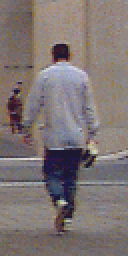

In [3]:
pos_images[1]

### Convert to Grayscale

In [27]:
#integral_img = integral_image(pos_images[1])

In [28]:
img1 = colorview(Gray, integral_img)

LoadError: [91mUndefVarError: integral_img not defined[39m

In [6]:
img1 = Array{Float32}(img1);

LoadError: [91mUndefVarError: img1 not defined[39m

In [7]:
img1_g = Array{Float32}(Gray.(img1))

LoadError: [91mUndefVarError: img1 not defined[39m

### Integral image

In [8]:
X = integral_image(img1_g[1,:,:])

LoadError: [91mUndefVarError: img1_g not defined[39m

In [9]:
using PyPlot

PyPlot.imshow(X, cmap="gray")

INFO: Recompiling stale cache file /Users/davidbuchacaprats/.julia/lib/v0.6/PyPlot.ji for module PyPlot.


LoadError: [91mUndefVarError: X not defined[39m

### From integral image to haar features

#### boxxdiff function

```
sum = boxdiff(integral_image, ytop:ybot, xtop:xbot)
sum = boxdiff(integral_image, CartesianIndex(tl_y, tl_x), CartesianIndex(br_y, br_x))
sum = boxdiff(integral_image, tl_y, tl_x, br_y, br_x)
```
An integral image is a data structure which helps in efficient calculation of sum of pixels in
a rectangular subset of an image. It stores at each pixel the sum of all pixels above it and to
its left. The sum of a window in an image can be directly calculated using four array
references of the integral image, irrespective of the size of the window, given the `yrange` and `xrange` of the window. 

Given an integral image 


        A - - - - - - B -
        - * * * * * * * -
        - * * * * * * * -
        - * * * * * * * -
        - * * * * * * * -
        - * * * * * * * -
        C * * * * * * D -
        - - - - - - - - -
The sum of pixels in the area denoted by * is given by S = D + A - B - C.


In [57]:
X[1:6,1:6]

6×6 Array{Float32,2}:
  0.466667   1.41961   2.89412    4.83529    7.24314   10.1098
  1.41961    4.29804   8.68627   14.4745    21.7176    30.3373
  2.89412    8.7451   17.5804    29.2157    43.7608    61.0588
  4.8902    14.7569   29.6039    49.1725    73.5647   102.545 
  7.40784   22.2706   44.5686    73.9765   110.58     154.059 
 10.3922    31.1843   62.3333   103.439    154.635    215.451 

In [59]:
boxdiff(X, 1:3, 1:3)

17.58039f0

In [62]:
sum(img1_g[1:3,1:3])

8.243137f0